In [2]:
#import statements

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/site-packages/traitlets/config/application.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/site-packages/traitlets/config/application.py", lin

AttributeError: _ARRAY_API not found

In [3]:
#Reading in ordinace data
ord = pd.read_excel("/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/Wind Ordinances 2025-2.xlsx")

In [4]:
#Examining the numerical ordiances
numeric_count = pd.to_numeric(ord.Value, errors='coerce').notna().sum()
print(f"Number of rows with numeric Value values: {numeric_count} out of {len(ord)} total rows.")

Number of rows with numeric Value values: 6389 out of 12282 total rows.


In [5]:
#Looking at the type of ordinanaces with numeric values
ord['is_numeric'] = pd.to_numeric(ord['Value'], errors='coerce').notna()

usable_ord = ord[ord['is_numeric']]
usable_ord.Feature.unique()

array(['Structures (Non-Participating)', 'Roads', 'Transmission', 'Noise',
       'Property Line (Non-Participating)', 'Maximum Height',
       'Blade Clearance', 'Railroads', 'Shadow Flicker',
       'Minimum Lot Size', 'Maximum Project Size',
       'Structures (Participating)', 'Property Line (Participating)',
       'Water', 'Tower Density', 'Other Wecs', 'Maximum Lot Size'],
      dtype=object)

### Exisiting Capabilities and Low-hanging Fruit

We have the capability to model setback ordiances for **structures** (see note below on particpating vs non-participating), **roads**, **transmission**, **railroads**, and **water**. Although we have not modeled **property line** ordinances for wind, we have the parcel dataset to do so (see note below on particpating vs non-participating).

We can easily create turbine specific binary exclusion layers for **maximum height** and **blade clearance** at the jurisdiction level.

### Medium-hanging fruit

**Lot and Project Size**

Minimum and Maximum Lot size as well as Maximum Project Size hinge on our interpretation of whether the supply curve grid cell represents a single farm. 

Maximum project size ranges from per acre capacity, to number of turbines to kW to turbines per parcel/lot. Max/min lot size are nearly all in acres.

***Project Size***

In [6]:
# Convert "per X acre" values to unified "per acre" for Maximum Project Size

# Filter for Maximum Project Size ordinances
max_project_data = usable_ord[usable_ord.Feature == 'Maximum Project Size'].copy()

print("Before conversion:")
print(f"Total Maximum Project Size ordinances: {len(max_project_data)}")
print("\nUnits breakdown (before):")
print(max_project_data.Units.value_counts())

# Function to convert "per X acre" to "per acre"
def convert_per_acre_units(row):
    units = row['Units']
    value = row['Value']
    
    # Skip if units is NaN, None, or empty
    if pd.isna(units) or units is None or str(units).strip() == '' or str(units).strip().lower() == 'nan':
        return value, units
    
    units = str(units).strip()
    
    # Look for pattern "per X acre" or similar variations
    per_acre_pattern = r'per\s+(\d+(?:\.\d+)?)\s+acres?'
    match = re.search(per_acre_pattern, units, re.IGNORECASE)
    
    if match:
        # Extract the number of acres
        acres = float(match.group(1))
        # Convert to per acre by dividing by the number of acres
        new_value = value / acres
        new_units = "per acre"
        return new_value, new_units
    
    # Return original if no conversion needed
    return value, units

# Apply the conversion
conversions_made = 0
for idx in max_project_data.index:
    original_value = max_project_data.loc[idx, 'Value']
    original_units = max_project_data.loc[idx, 'Units']
    
    new_value, new_units = convert_per_acre_units(max_project_data.loc[idx])
    
    if new_units != original_units:
        print(f"Converting: {original_value} {original_units} → {new_value:.3f} {new_units}")
        # Update the original dataframe
        usable_ord.loc[idx, 'Value'] = new_value
        usable_ord.loc[idx, 'Units'] = new_units
        conversions_made += 1

print(f"\nTotal conversions made: {conversions_made}")

# Show results after conversion
max_project_data_after = usable_ord[usable_ord.Feature == 'Maximum Project Size'].copy()
# print("\nAfter conversion:")
# print("Units breakdown (after):")
# print(max_project_data_after.Units.value_counts())

# # Show some statistics for the "per acre" values
per_acre_data = max_project_data_after[max_project_data_after.Units == 'per acre']
# if len(per_acre_data) > 0:
#     print(f"\nPer acre values statistics:")
#     print(f"Count: {len(per_acre_data)}")
#     print(f"Mean: {per_acre_data.Value.mean():.3f}")
#     print(f"Median: {per_acre_data.Value.median():.3f}")
#     print(f"Min: {per_acre_data.Value.min():.3f}")
#     print(f"Max: {per_acre_data.Value.max():.3f}")

Before conversion:
Total Maximum Project Size ordinances: 116

Units breakdown (before):
Units
turbines                                                                                               32
turbine(s) per parcel/lot                                                                              31
kW                                                                                                     20
per 5 acres                                                                                             5
per 2 acres                                                                                             2
per 100 acres                                                                                           2
per 20 acres                                                                                            1
wind turbine generators (number of turbines)                                                            1
per 1 acre                                               

In [7]:
#converting all different ways of saying #number turbines into a single unit
count_units = ["turbines", "nan", "wind turbines", "installations", "turbines (count)", "wind turbine generators (number of turbines)"]

# Convert units in max_project_data_after to "num_turbines" for units in count_units list
for idx in max_project_data_after.index:
    current_unit = max_project_data_after.loc[idx, 'Units']
    if current_unit in count_units or (pd.isna(current_unit) and np.nan in count_units):
        max_project_data_after.loc[idx, 'Units'] = 'num_turbines'

# print("After converting count units to 'num_turbines':")
# print("Units breakdown:")
# print(max_project_data_after.Units.value_counts())

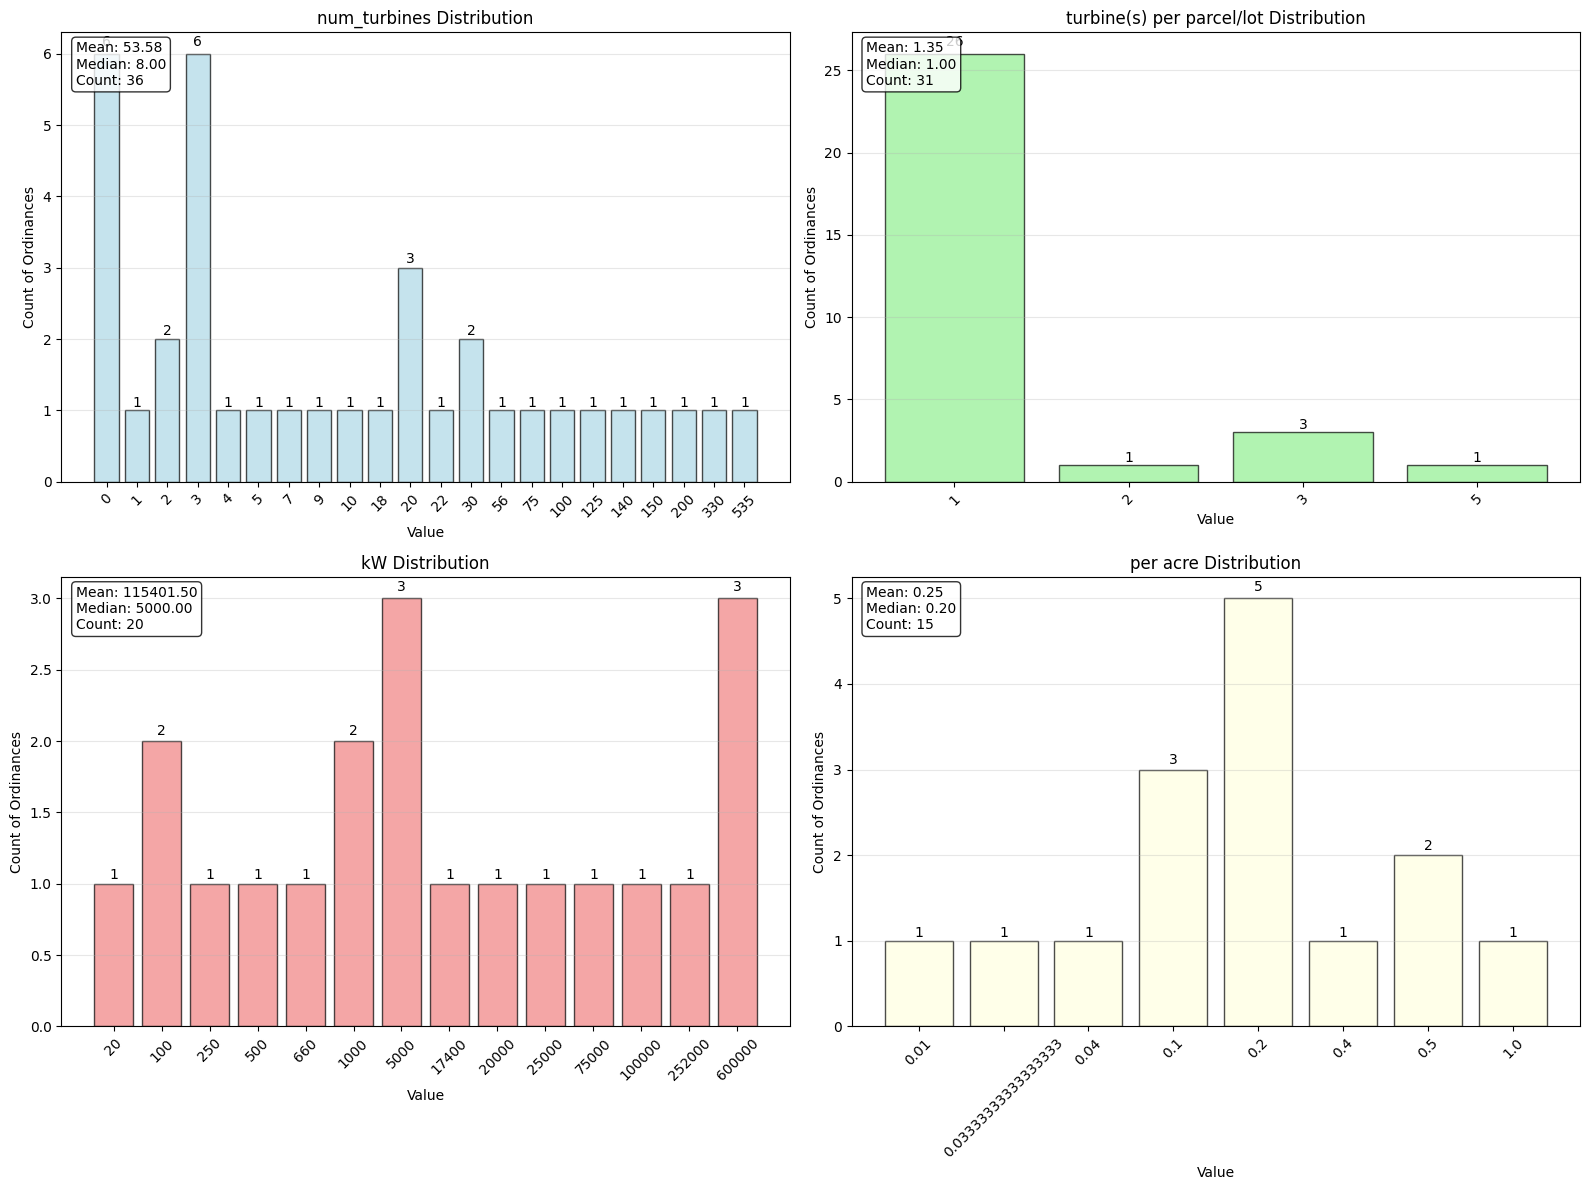

In [8]:
# Create bar plots for different unit types in Maximum Project Size data with summary stats
target_units = ['num_turbines', 'turbine(s) per parcel/lot', 'kW', 'per acre']

# Create 4 separate bar plots for different unit types in Maximum Project Size data
target_units = ['num_turbines', 'turbine(s) per parcel/lot', 'kW', 'per acre']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for i, unit in enumerate(target_units):
    # Filter data for this unit
    unit_data = max_project_data_after[max_project_data_after.Units == unit]
    
    if len(unit_data) > 0:
        # Get numeric values
        values = pd.to_numeric(unit_data['Value'], errors='coerce').dropna()
        
        if len(values) > 0:
            # Create value counts for bar plot
            value_counts = values.value_counts().sort_index()
            
            # Create bar plot
            bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                             color=colors[i], alpha=0.7, edgecolor='black')
            
            # Set x-axis labels to actual values
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels(value_counts.index, rotation=45)
            
            # Add count labels on top of bars
            for j, count in enumerate(value_counts.values):
                axes[i].text(j, count + count*0.01, str(count), ha='center', va='bottom')
            
            # Add summary statistics as text
            stats_text = f'Mean: {values.mean():.2f}\nMedian: {values.median():.2f}\nCount: {len(values)}'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            axes[i].set_title(f'{unit} Distribution')
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Count of Ordinances')
        else:
            axes[i].text(0.5, 0.5, f'No valid numeric data\nfor {unit}', 
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'{unit} Distribution (n=0)')
    else:
        axes[i].text(0.5, 0.5, f'No data found\nfor {unit}', 
                    transform=axes[i].transAxes, ha='center', va='center')
        axes[i].set_title(f'{unit} Distribution (n=0)')
    
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

***Lot Size***

In [ ]:
# Simple conversion of square feet to acres for Minimum Lot Size
lot_size_data = usable_ord[usable_ord['Feature'] == 'Minimum Lot Size'].copy()

# Convert square feet to acres (1 acre = 43,560 square feet)
mask_sqft = lot_size_data['Units'] == 'square feet'
lot_size_data.loc[mask_sqft, 'Value'] = lot_size_data.loc[mask_sqft, 'Value'] / 43560
lot_size_data.loc[mask_sqft, 'Units'] = 'acres'

# # Show the conversion results
# print(f"Converted {mask_sqft.sum()} entries from square feet to acres")
# print("\nMinimum Lot Size units after conversion:")
# print(lot_size_data['Units'].value_counts())


Minimum Lot Size - Units breakdown:
  acres: 146 ordinances

Maximum Lot Size - Units breakdown:
  acres: 17 ordinances


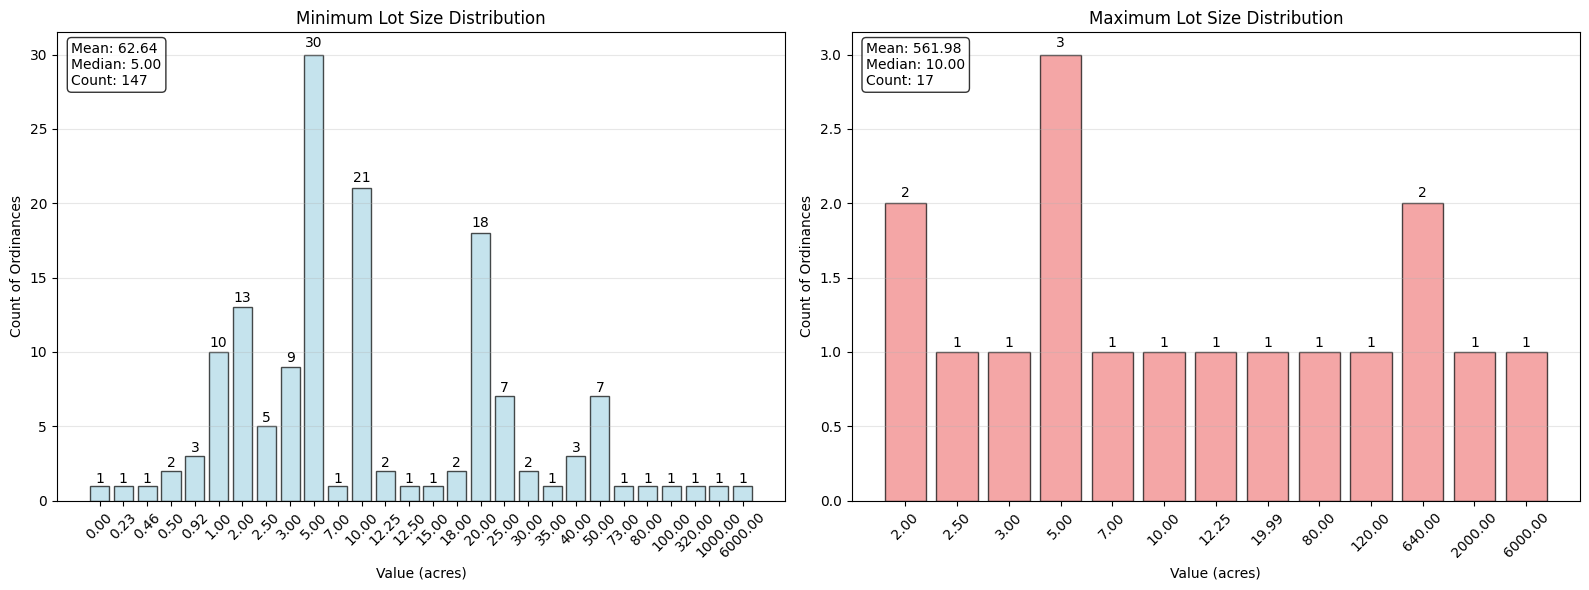

In [12]:
# Create bar plots for Minimum and Maximum Lot Size features
lot_features = ['Minimum Lot Size', 'Maximum Lot Size']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['lightblue', 'lightcoral']

for i, feature in enumerate(lot_features):
    # Filter data for this feature
    if feature == 'Minimum Lot Size':
        # Use the converted data from previous cell where all units are in acres
        feature_data = lot_size_data
    else:
        feature_data = usable_ord[usable_ord['Feature'] == feature]
    
    if len(feature_data) > 0:
        # Get numeric values
        values = pd.to_numeric(feature_data['Value'], errors='coerce').dropna()
        
        if len(values) > 0:
            # Create value counts for bar plot
            value_counts = values.value_counts().sort_index()
            
            # Create bar plot
            bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                             color=colors[i], alpha=0.7, edgecolor='black')
            
            # Set x-axis labels to actual values (formatted to 2 decimal places)
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels([f'{val:.2f}' for val in value_counts.index], rotation=45)
            
            # Add count labels on top of bars
            for j, count in enumerate(value_counts.values):
                axes[i].text(j, count + count*0.01, str(count), ha='center', va='bottom')
            
            # Add summary statistics as text
            stats_text = f'Mean: {values.mean():.2f}\nMedian: {values.median():.2f}\nCount: {len(values)}'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            axes[i].set_title(f'{feature} Distribution')
            axes[i].set_xlabel('Value (acres)')
            axes[i].set_ylabel('Count of Ordinances')
            
            # Show units breakdown
            units_info = feature_data['Units'].value_counts()
            print(f"\n{feature} - Units breakdown:")
            for unit, count in units_info.items():
                print(f"  {unit}: {count} ordinances")
                
        else:
            axes[i].text(0.5, 0.5, f'No valid numeric data\nfor {feature}', 
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'{feature} Distribution (n=0)')
    else:
        axes[i].text(0.5, 0.5, f'No data found\nfor {feature}', 
                    transform=axes[i].transAxes, ha='center', va='center')
        axes[i].set_title(f'{feature} Distribution (n=0)')
    
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Noise**

93% of the ~740 are max dBA ordinances. We currently have the capability to apply single turbine max noise threshold setback (35-60 dBA?). We are developing the capability to integrate multi-turbine plant noise into bespoke siting (which may be more representative of the ordinance).

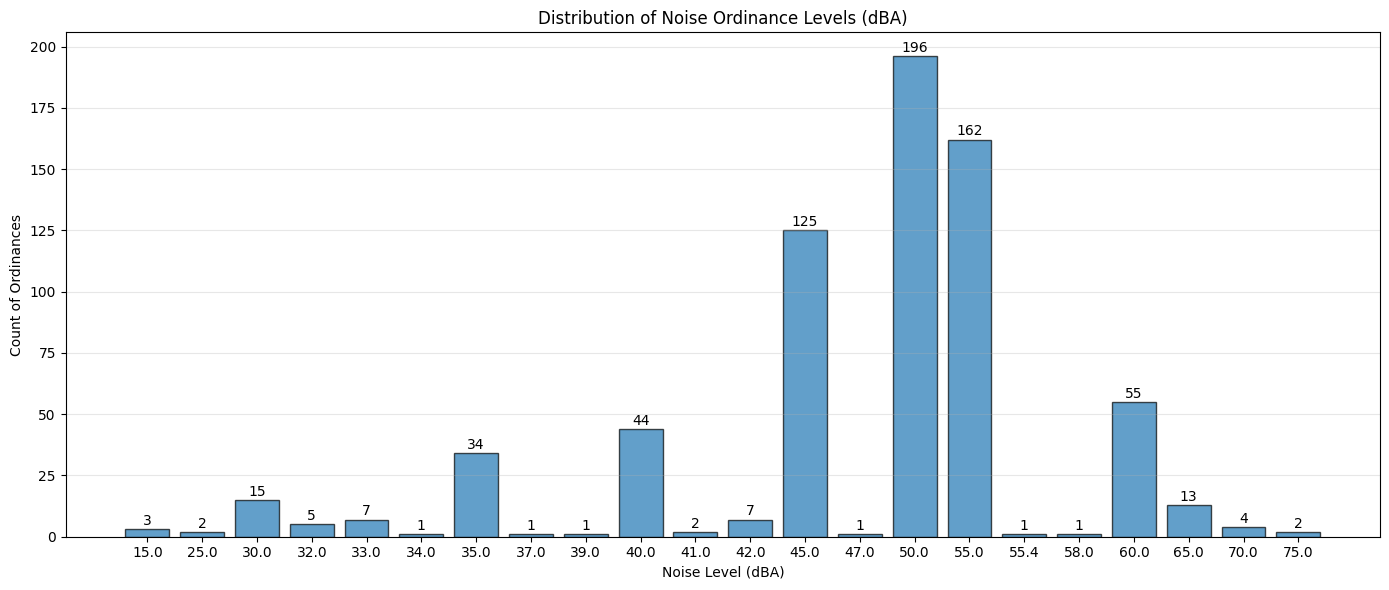

Noise ordinances with dBA units: 682
Mean: 49.0 dBA
Median: 50.0 dBA
Min: 75.0 dBA
Max: 15.0 dBA
Standard deviation: 8.2 dBA
10th percentile: 60.0 dBA
25th percentile: 55.0 dBA
50th percentile: 50.0 dBA
75th percentile: 45.0 dBA
90th percentile: 39.1 dBA


In [44]:
# Plot histogram of noise ordinance levels in dBA
noise_data = usable_ord[(usable_ord.Feature == 'Noise') & (usable_ord.Units == 'dBA')]

if len(noise_data) > 0:
    # Get the values and convert to numeric
    noise_values = pd.to_numeric(noise_data['Value'], errors='coerce')
    
    # Create bar plot with value counts
    value_counts = noise_values.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    # Use range for equal spacing, then set custom labels
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7)
    plt.xlabel('Noise Level (dBA)')
    plt.ylabel('Count of Ordinances')
    plt.title('Distribution of Noise Ordinance Levels (dBA)')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels to show the actual dBA values
    plt.xticks(x_positions, value_counts.index)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics

    #reversed values since lower is more restrictive
    print(f"Noise ordinances with dBA units: {len(noise_data)}")
    print(f"Mean: {noise_values.mean():.1f} dBA")
    print(f"Median: {noise_values.median():.1f} dBA")
    print(f"Min: {noise_values.max():.1f} dBA")
    print(f"Max: {noise_values.min():.1f} dBA")
    print(f"Standard deviation: {noise_values.std():.1f} dBA")
    print(f"10th percentile: {noise_values.quantile(0.90):.1f} dBA")
    print(f"25th percentile: {noise_values.quantile(0.75):.1f} dBA")
    print(f"50th percentile: {noise_values.quantile(0.50):.1f} dBA")
    print(f"75th percentile: {noise_values.quantile(0.25):.1f} dBA")
    print(f"90th percentile: {noise_values.quantile(0.10):.1f} dBA")
    
    # # Show value counts for unique levels
    # print("\nValue counts for each noise level:")
    # value_counts = noise_values.value_counts().sort_index()
    # for level, count in value_counts.items():
    #     print(f"  {level} dBA: {count} ordinances")
        
else:
    print("No noise ordinances with dBA units found in the data.")

### Tough to reach fruit

**Shadow Flicker**

We have developed a shadow flicker modeling methodology, but apparently it is unrealistic, and results in overly restrictive outputs

### Outstanding questions

**How to handle participating and non-participating setbacks?**

Jurisdictions have participating setbacks have non-participating setbacks, so we will need to determine the appropriate handling.

In [9]:
# Check specific ordinance types for participating vs non-participating patterns
target_features = [
    'Structures (Non-Participating)', 
    'Property Line (Non-Participating)', 
    'Structures (Participating)', 
    'Property Line (Participating)'
]

print("Analysis of Participating vs Non-Participating for Structures and Property Lines:\n")

# Check which of our target features exist in the data
existing_features = []
for feature in target_features:
    if feature in usable_ord.Feature.values:
        count = len(usable_ord[usable_ord.Feature == feature])
        existing_features.append(feature)
        print(f"{feature}: {count} ordinances")
    else:
        print(f"{feature}: NOT FOUND in data")

print("\n" + "="*80 + "\n")

# Analyze for Structures
structures_participating = 'Structures (Participating)'
structures_non_participating = 'Structures (Non-Participating)'

if structures_participating in existing_features and structures_non_participating in existing_features:
    print("STRUCTURES ANALYSIS:")
    
    # Get jurisdictions for each type
    part_jurisdictions = set(usable_ord[usable_ord.Feature == structures_participating]['County Subdivision FIPS Code'].unique())
    non_part_jurisdictions = set(usable_ord[usable_ord.Feature == structures_non_participating]['County Subdivision FIPS Code'].unique())
    
    # Find patterns
    both_types = part_jurisdictions & non_part_jurisdictions
    only_participating = part_jurisdictions - non_part_jurisdictions
    only_non_participating = non_part_jurisdictions - part_jurisdictions
    
    total_jurisdictions = len(part_jurisdictions | non_part_jurisdictions)
    
    print(f"  Total jurisdictions with structure ordinances: {total_jurisdictions}")
    print(f"  Jurisdictions with BOTH participating and non-participating: {len(both_types)} ({len(both_types)/total_jurisdictions*100:.1f}%)")
    print(f"  Jurisdictions with ONLY participating: {len(only_participating)} ({len(only_participating)/total_jurisdictions*100:.1f}%)")
    print(f"  Jurisdictions with ONLY non-participating: {len(only_non_participating)} ({len(only_non_participating)/total_jurisdictions*100:.1f}%)")

print("\n" + "-"*60 + "\n")

# Analyze for Property Lines
property_participating = 'Property Line (Participating)'
property_non_participating = 'Property Line (Non-Participating)'

if property_participating in existing_features and property_non_participating in existing_features:
    print("PROPERTY LINE ANALYSIS:")
    
    # Get jurisdictions for each type
    part_jurisdictions = set(usable_ord[usable_ord.Feature == property_participating]['County Subdivision FIPS Code'].unique())
    non_part_jurisdictions = set(usable_ord[usable_ord.Feature == property_non_participating]['County Subdivision FIPS Code'].unique())
    
    # Find patterns
    both_types = part_jurisdictions & non_part_jurisdictions
    only_participating = part_jurisdictions - non_part_jurisdictions
    only_non_participating = non_part_jurisdictions - part_jurisdictions
    
    total_jurisdictions = len(part_jurisdictions | non_part_jurisdictions)
    
    print(f"  Total jurisdictions with property line ordinances: {total_jurisdictions}")
    print(f"  Jurisdictions with BOTH participating and non-participating: {len(both_types)} ({len(both_types)/total_jurisdictions*100:.1f}%)")
    print(f"  Jurisdictions with ONLY participating: {len(only_participating)} ({len(only_participating)/total_jurisdictions*100:.1f}%)")
    print(f"  Jurisdictions with ONLY non-participating: {len(only_non_participating)} ({len(only_non_participating)/total_jurisdictions*100:.1f}%)")

Analysis of Participating vs Non-Participating for Structures and Property Lines:

Structures (Non-Participating): 874 ordinances
Property Line (Non-Participating): 1056 ordinances
Structures (Participating): 159 ordinances
Property Line (Participating): 67 ordinances


STRUCTURES ANALYSIS:
  Total jurisdictions with structure ordinances: 895
  Jurisdictions with BOTH participating and non-participating: 138 (15.4%)
  Jurisdictions with ONLY participating: 21 (2.3%)
  Jurisdictions with ONLY non-participating: 736 (82.2%)

------------------------------------------------------------

PROPERTY LINE ANALYSIS:
  Total jurisdictions with property line ordinances: 1071
  Jurisdictions with BOTH participating and non-participating: 52 (4.9%)
  Jurisdictions with ONLY participating: 15 (1.4%)
  Jurisdictions with ONLY non-participating: 1004 (93.7%)


Unit Analysis

In [10]:
# For each ordinance type (Feature), display unique units and their counts within usable ordinances
print("Units and counts for each ordinance feature type (usable ordinances only):\n")

for feature in sorted(usable_ord.Feature.unique()):
    feature_data = usable_ord[usable_ord.Feature == feature]
    unit_counts = feature_data.Units.value_counts()
    
    print(f"Feature: {feature}")
    print(f"Total ordinances: {len(feature_data)}")
    print("Units breakdown:")
    for unit, count in unit_counts.items():
        percentage = (count / len(feature_data)) * 100
        print(f"  {unit}: {count} ({percentage:.1f}%)")
    print("-" * 60)

Units and counts for each ordinance feature type (usable ordinances only):

Feature: Blade Clearance
Total ordinances: 571
Units breakdown:
  feet: 570 (99.8%)
  percent of tower height: 1 (0.2%)
------------------------------------------------------------
Feature: Maximum Height
Total ordinances: 522
Units breakdown:
  feet: 516 (98.9%)
  meters: 4 (0.8%)
------------------------------------------------------------
Feature: Maximum Lot Size
Total ordinances: 17
Units breakdown:
  acres: 17 (100.0%)
------------------------------------------------------------
Feature: Maximum Project Size
Total ordinances: 116
Units breakdown:
  turbines: 32 (27.6%)
  turbine(s) per parcel/lot: 31 (26.7%)
  kW: 20 (17.2%)
  per 5 acres: 5 (4.3%)
  per 2 acres: 2 (1.7%)
  per 100 acres: 2 (1.7%)
  per 20 acres: 1 (0.9%)
  wind turbine generators (number of turbines): 1 (0.9%)
  per 1 acre: 1 (0.9%)
  turbines (count): 1 (0.9%)
  installations: 1 (0.9%)
  wind turbines: 1 (0.9%)
  turbines or generating 